## ExperiWatt - Gehirn und Energie
In diesem Arbeitsblatt lernt ihr eigenständig eine vollständige Bearbeitung, Visualisierung und Analyse von euren eigenen EEG Daten durchzuführen. Dafür benötigen wir einige Funktionen des Python Softwarepackages MNE. In dem Dokument **"MNE Funktionen"** findet ihr eine Liste an Funktionen die ihr dafür braucht.

Der Programmcode in den grau hinterlegten Felder kann durch die Tastenkomination "Strg" + "Enter" ausgeführt werden. Sie enhält außerdem **Kommentare** (gekennzeichnet durch das # -Symbol), die euch Hinweise dazu geben, welche Funktion ihr für die jeweilige Aufgabe verwenden müsst. 
Funktionen sind Programmstücke die eine bestimmte Aufgabe erfüllen. Hier ist ein Beispiel: `plot_signal(raw, start=0, end=None, electrodes=range(24)):`. Diese Funktion hat den Namen `plot_signal` und nimmt die Parameter `raw` (Daten), `start`, `end` und `electrodes`. Schaut euch beim Verwenden der Funktionen gut an welche Parameter diese Funktion braucht um zu funktionieren. Drei Punkte `...` geben euch einen Tipp wo ihr eigene Werte einsetzen müsst. 

An der Punkteanzahl die ihr für jede Aufgabe bekommt könnt ihr den Schwierigkeitsgrad der Aufgabe abschätzen. Steht dort keine Punktzahl, ist der Programmcode schon fertig und ihr müsst ihn lediglich ausführen. 

Gliederung:
1) EEG Daten laden

2) Elektroden Montage Mapping 

3) Daten Betrachtung

4) Frequenz Stärken Spektrum

5) Preprocessing (Säubern der Daten)


In [ ]:
%gui qt

In [ ]:
%matplotlib notebook

In [1]:
# zunächst importieren wir das MNE Package, damit wir es verwenden können
import mne 
from mne import viz
from mne.io import RawArray
from mne.preprocessing import ICA
from mne_icalabel import label_components
from pyprep.find_noisy_channels import find_bad_by_ransac
import matplotlib.pyplot as plt
import numpy as np
from meegkit.detrend import detrend
from meegkit.dss import dss_line
import pandas as pd
from helper_functions import *

2024-02-24 14:43:27,229 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-02-24 14:43:27,233 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


### 1) EEG Daten laden
Um unsere Daten einsehen zu können müssen wir sie aus unserem Ordner wo wir sie gespeichert haben hier in unser Programm laden.

<div class='alert alert-warning'>
<b>ToDo</b> (1 Punkt): Ersetze die '...' durch den Namen der EEG Aufzeichnungsdatei (Tipp: die Endung '.vhdr' muss ebenfalls ausgeschrieben werden). 
</div>

In [2]:
# Name der Datei
fdir = 'Experiment/output_data/'
fname = 'Jiachen_Test_2024-02-21_11-16-58.vhdr'

# Lade die Datei. In MNE werden EEG Datensätze im "Raw" format gespeichert.
raw = mne.io.read_raw_brainvision(fdir+fname, preload=True)

Extracting parameters from Experiment/output_data/Jiachen_Test_2024-02-21_11-16-58.vhdr...
Setting channel info structure...
Reading 0 ... 316397  =      0.000 ...   632.794 secs...


### 2) Elektroden Montage Mapping
Das Softwarepackage MNE ermöglicht es uns mit einer standardisierten Map die EEG Aktivität auf die richtige Stelle auf dem Kopf zu projezieren. Die folgende Abbildung zeigt wie die Montage für das EEG System aussehen sollte.
Die Standardmontage heißt `standard_1020`.
<br>
<br>

<div>
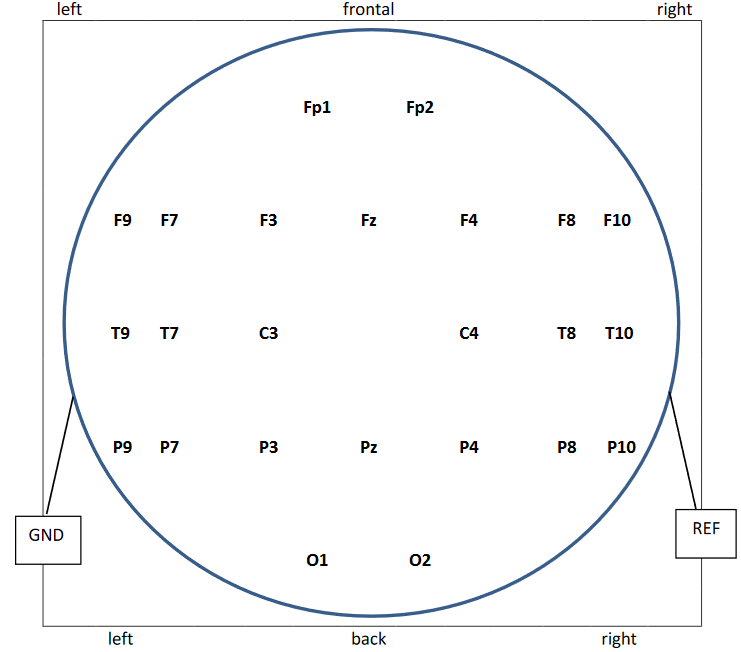
</div>

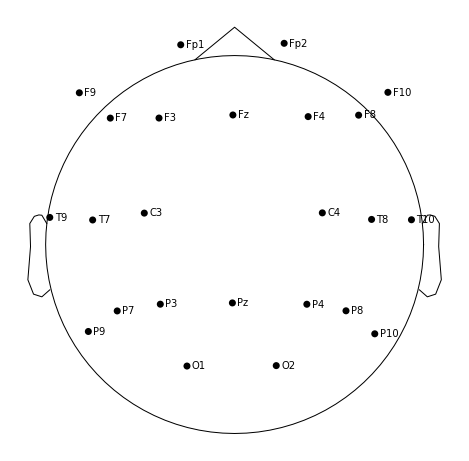

In [3]:
# Standard Map laden und an Datensatz zufügen
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

# Erstelle ein Plot der Standard Montage und vergleiche die Reihenfolge/den Aufbau der Elektroden mit der obigen Abbildung. 
fig = raw.plot_sensors(show_names=True)

### 2) Daten Betrachtung
Jetzt können wir einen ersten Blick auf die Daten werfen!

<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): Erstelle einen Plot der EEG Daten. Verwende dazu die mne function <tt>plot_signal()</tt>, welche als Parameter das Datenset (<tt>raw</tt>), eine Startzeit und Endzeit (in Sekunden), sowie Elektrodennummer(n) annimmt. 
    Beispiel:  <tt>plot_signal(raw, start=20, end=600, electrodes=[5, 21])</tt>. Betrachtet die ganze Länge der Daten, und notiert euch Elektroden, die stark flukuturieren oder starke Störungen aufweisen.
</div>

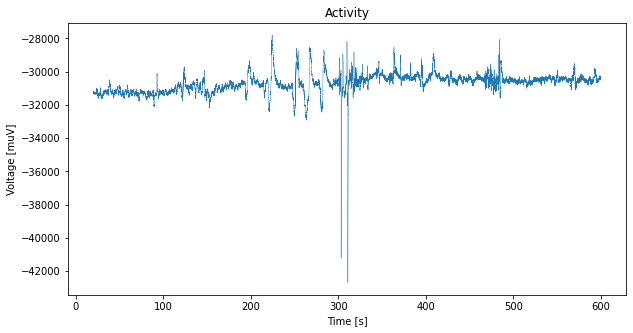

In [4]:
plot_signal(raw, start=20, end=600, electrodes=[21])
plt.show()

Falls ihr eine Elektrode (oder mehrere) entdeckt die viel höhere Werte hat als alle anderen und extrem fluktuiert, notiert sie euch. Kanäle mit sehr schlechten Signal werden wir in einem späteren Schritt entfernen.

### 4) Frequenz Stärken Spektrum
Ein elektrisches Signal besteht aus Wellen, die sich oft in vielen verschiedenen Frequenzen bewegen.  
Stellt euch vor, ein Signal ist zusammengesetzt aus 3 verschiedenen Wellen: Welle 1 hat eine Freuqenz von 1Hz, Welle 2 hat eine Frequenz von 5Hz, und Welle 3 hat eine Frequenz von 10Hz. Welle 2 hat außerdem eine höhere Amplitude als die anderen beiden Wellen.

<br>
<br>

<div>
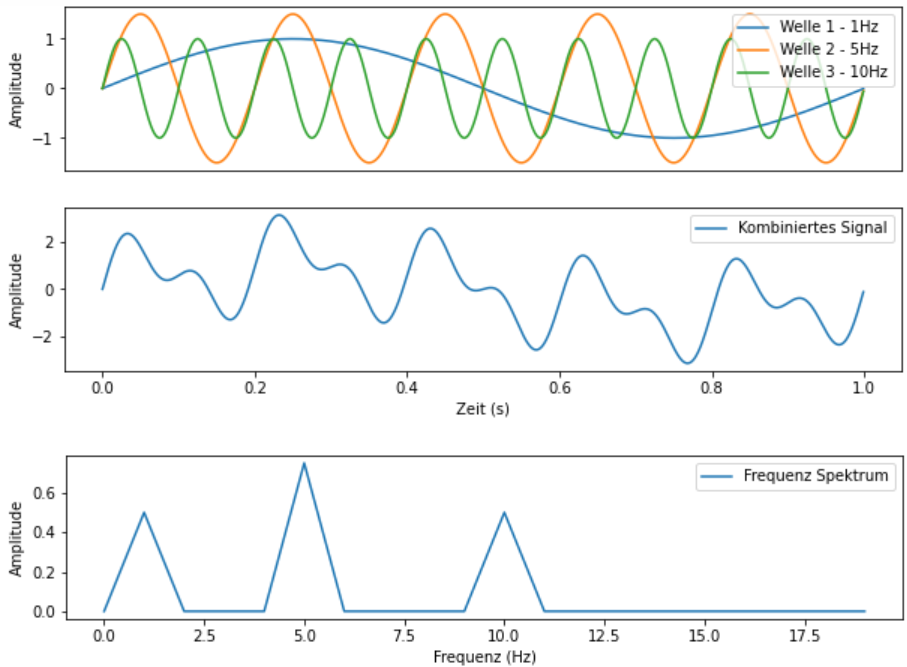
</div>

In der dritten Abbildung seht ihr deutlich, dass die Frequenzen der drei Wellen (1, 5 und 10 Hz) aufgespürt wurden. Es ist auch sichtbar, dass Welle 2 mit eine Frequenz von 5Hz eine höhere Amplitude hat als die anderen. 5Hz sind also in diesem Signal am stärksten vertreten.

EEG Daten sind ebenfalls aus Wellen von verschiedenen Frequenzen zusammengesetzt, da Neuronen in unserem Gehirn unterschiedlich schnelle Signale senden und miteinander kommunizieren. Jede Frequenz trägt unterschiedlich viel zur gesamten Leistung der Gehirnaktivität bei. 

In diesem Aufgabenteil wollen wir herausfinden welche Frequenzen in unseren EEG Daten vorhanden sind, und wie stark jede Frequenz vertreten ist. 
Mit Hilfe der sogenannten Fourier Analyse ist es möglich die Amplituden (auch Power spectrum density genannt) jeder Frequenz des EEG Signals herauszufinden. Der resultierende Graph wird auch Power Spektrum genannt.

In der folgenden Abbildung seht ihr wie ein typisches EEG Spektrum ausseht.


<div>
<img src="attachment:grafik-2.png" width="700"/>
</div>



<div class='alert alert-warning'>
    <b>ToDo</b> (2 Punkte): Verwendet die `plot_psd()` Funktion (welche im Hintergrund die Fourier Analyse durchführt) um das Power Spektrum euer Daten zu berechnen, und gebt verschiedene Werte für `fmin` und `fmax` ein (niedrigste und höchste Frequenz). Vergleicht euer Spektrum mit dem obigen Beispiel (achtet auf die x-Achse) und beschreibt was ihr seht.
</div>

In [ ]:
raw.plot_psd(fmin=0, fmax=100)
plt.show()

### 5) Preprocessing
Die mit der EEG Kappe gemessene Aktivität ist leider nicht reine Gehirnaktivität. Da die Elektroden in der Kappe sehr sensitiv sind nehmen sie auch jede andere Veränderung von elektrischem Potenzial wahr. 
Wir werden die folgenden Rauschfaktoren Schritt für Schritt aus dem Signal entfernen:

5.1) Vorbereitungen

5.2) Kanäle mit unzreichendem Signal

5.3) Augenblinzeln, Herzschlag und andere Muskelstörfaktoren

5.4) Stromleitungen

#### 5.1) Vorbereitungen

Führt erst ein Downsampling der Datendurch, so reduziert ihr die Datenpunkte - dann geht das Bearbeiten schneller!

In [ ]:
resample_freq = 200
_ = raw.resample(resample_freq)

Unser Experiment besteht aus zwei Teilen: dem passiven Teil in dem ihr euren Blick auf das Kreuz fixiert, und dem aktiven Teil in dem ihr Zahlen zusammen addiert habt. Unterteilt die Daten in diese beiden Abschnitte - Passiv und Aktiv! Die Variablen die auf die jeweiligen Daten verweisen heißen ab jetzt ```raw_passive``` (für das passive Datenset) und ```raw_active``` (für das aktive Datenset)

In [ ]:
raw_passive, raw_active = split_dataset(raw)

#### 5.2) Kanäle mit unzreichendem Signal behandeln

Es ist möglich, dass einige Elektroden/Kanäle die Gehirnaktivität nicht richtig messen konnten und unbrauchbar sind - bei Trockenelektroden ist es normal, dass dies circa 20% der Kanäle sind. Wir müssen herausfinden welche Kanäle betroffen sind, um sie aus unserem Datenset zu entfernen. Dafür könnt ihr die Funktion `detect_bad_channels()` verwenden. Bei dieser Methode wird die Aktivität eines Kanals durch seine Nachbarkanäle vorhergesagt. Diese Vorhersage wird mit der echten Aktivität verglichen. Einen Kanal mit schlechtem Signal erkennt man daran, dass dieser auf Grund von vielen Störfaktoren nicht vorhergesagt werden kann.

Notiere welche Kanäle detektiert wurden und schaue ob diese mit den Kanälen übereinstimmen, die euch während der Datenerhebung bereits als unzureichend aufgefallen sind.


In [ ]:
# Finde Kanäle mit schlechtem signal 
bads_passive = detect_bad_channels(raw_passive, corr_thresh=0.4)
print(bads_passive)
bads_active = detect_bad_channels(raw_active, corr_thresh=0.4)
print(bads_active)

In [ ]:
raw_passive_cleaned = remove_bad_channels(bads_passive, raw_passive)
raw_active_cleaned = remove_bad_channels(bads_active, raw_active)

In [ ]:
plot_signal(raw_passive_cleaned, start=10, end=12, electrodes=range(24))

#### 2) Baseline Correction
Manche Kanäle\Elektroden weisen durch Bewegung oder Zustand der Kopfhaut (e.g. durch Schwitzen) flukturierende Hintergrundaktivität auf und müssen entfernt werden. Verwende hierzu die Funktion `detrend_baselines()`

In [ ]:
# Verwende die Funktion "detrend_baselines()" um die Aktivität um die Baseline um die 0 mV zu bringen
detrend_baselines(raw_passive_cleaned)
detrend_baselines(raw_active_cleaned)

In [ ]:
# Schaue dir an wie die Daten vorher aussehen
plot_signal(raw_passive_cleaned, start=0, end=1, electrodes=range(24))
plot_signal(raw_active_cleaned, start=0, end=2, electrodes=range(24))

#### 3) Störungen durch Stromleitungen
Beim Betrachten des Power Density Spectrums ist euch sicher ein starke Spitze um 50Hz aufgefallen. Das sind die Wechselstromleitungen die von den EEG Elektroden aufgezeichnet werden. Damit wir dieses Signal loswerden können und dabei möglichst wenig der gemessenen Gehirnaktivität löschen, verwenden wir den sogenannten ZapLine Algorithmus. Dieser wurde in der Funktion `dss_line()` implementiert. Achtet darauf die richtige Frequenz der Stromleitung einzugeben. Passe außerdem den Parameter 'nremove' an, jenach Stärke des Störsignals. Je höher der Wert desto stärker die Filter-Wirkung

In [ ]:
# Verwende "dss_line()" für das "passive" Datenset ...
X_zapline_passive, noise = dss_line(raw_passive_cleaned.get_data().T, fline=50, sfreq=raw_passive_cleaned.info['sfreq'], nremove=12)
raw_passive_zapline = RawArray(X_zapline_passive.T, raw_passive_cleaned.info)

# ... und für das "aktive"
X_zapline_active, noise = dss_line(raw_active_cleaned.get_data().T, fline=50, sfreq=raw_active_cleaned.info['sfreq'], nremove=12)
raw_active_zapline = RawArray(X_zapline_active.T, raw_active_cleaned.info)

In [ ]:
# Kontrolliere das Ergebnis indem du das "neue" Power Spectrum plottest. Falls du noch einen Peak bei 50Hz siest, 
# erhöhe den Wert für "nremove" in der "dss_line()" Funktion
raw_passive_zapline.plot_psd(0, 100)
plt.show()

raw_active_zapline.plot_psd(0, 100)
plt.show()

In [ ]:
# Filtere außerdem die 0.5Hz Leitung aus dem Signal
raw_passive_filtered = raw_passive_zapline.copy()
_ = raw_passive_filtered.filter(l_freq=1, h_freq=None)
raw_active_filtered = raw_active_zapline.copy()
_ = raw_active_filtered.filter(l_freq=1, h_freq=None)

#### 4) Augenblinzeln, Herzschlag und andere Muskelstörfaktoren
In diesem Abschnitt werden wir Störfaktoren wie Augenblinzeln und den Herzschlag aufspüren, wofür wir die sogenannte Independent Component Analysis (ICA) verwenden werden. Diese Analysemethode macht es möglich individuelle Störfaktoren aufzuspüren, die auf verschiedene Kanäle verteil sein können.

In [ ]:
# Verwende ICA - passive
ica_passive = ICA(n_components=10, max_iter="auto", random_state=97)
_ = ica_passive.fit(raw_passive_filtered)

# active
ica_active = ICA(n_components=10, max_iter="auto", random_state=97)
_ = ica_active.fit(raw_active_filtered)

In [ ]:
explained_var_ratio = ica_passive.get_explained_variance_ratio(
    raw_passive_filtered, components=[3], ch_type="eeg"
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by first component: "
    f"{ratio_percent}%"
)

In [ ]:
ica_active.plot_sources(raw_active_filtered, show_scrollbars=False)
plt.show()

In [ ]:
ica_passive.plot_sources(raw_passive_filtered, show_scrollbars=False)
plt.show()

Findet heraus was für ein Signal hinter den Komponenten steckt - Gehirnaktivität, Augenzwinkern, Herzschlag, oder Rauschen. Verwendet dafür die Funktion `label_components()`

In [ ]:
ic_labels_passive = label_components(raw_passive_filtered, ica_passive, method="iclabel")
ic_labels_active = label_components(raw_active_filtered, ica_active, method="iclabel")

In [ ]:
print(ic_labels_passive["labels"])
print(ic_labels_active["labels"])

In [ ]:
# entferne nun alle ICA Komponenten, die nicht als "brain" oder "other" klassifiziert wurden. 
labels_passive = ic_labels_passive["labels"]
labels_active = ic_labels_active["labels"]
exclude_idx_passive = [
    idx for idx, label in enumerate(labels_passive) if label not in ["brain", "other"]
]
exclude_idx_active = [
    idx for idx, label in enumerate(labels_active) if label not in ["brain", "other"]
]
print(f"Excluding these ICA components: {exclude_idx_passive}")
print(f"Excluding these ICA components: {exclude_idx_active}")

In [ ]:
reconst_raw_passive = raw_passive_filtered.copy()
_ = ica_passive.apply(reconst_raw_passive, exclude=exclude_idx_passive)

reconst_raw_active = raw_active_filtered.copy()
_ = ica_active.apply(reconst_raw_active, exclude=exclude_idx_active)

Betrachtet die Daten noch einmal nach dem ihr die Preprocessing Schritte durchgeführt habt. Was hat sich verändert? 

In [ ]:
reconst_raw_active.plot()

In [ ]:
# Schaut euch an wie die Daten vorher aussehen
plot_signal(reconst_raw_active, electrodes=range(24))
plot_signal(reconst_raw_passive, electrodes=range(24))

### Topography

Als nächstes wollen wir sehen wie die gemessene Aktivität über die Elektroden (welche verschiedene Bereiche des Gehirns messen) verteilt ist. Da wir im obigen Schritt die Elektrodenposition bereits mit den Daten gelinkt haben, können wir die Aktivität nun für die ganze EEG Kappe grafisch darstellen.   

Dafür müssen wir uns erst einen Zeitpunkt aussuchen den wir betrachten wollen.

In [ ]:
%matplotlib notebook 

In [ ]:
evoked = mne.EvokedArray(np.array(reconst_raw_passive.get_data()), raw_passive_filtered.info)
times = np.arange(0.05, 0.151, 0.01)
evoked.animate_topomap(times=times, ch_type="eeg", frame_rate=2, blit=False)

In [ ]:
# wähle einen Zeitpunkt (in Sekunden)
zeitpunkt = 100
topography_data_active = np.array(reconst_raw_active.get_data())[:, zeitpunkt]
topography_data_passive = np.array(reconst_raw_passive.get_data())[:, zeitpunkt]

# Erstelle einen Topographie Plot
viz.plot_topomap(topography_data_active, raw_active.info)
viz.plot_topomap(topography_data_passive, raw_passive.info)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,2))
plt.plot(freqs, 10 * np.log10(psds.T / (1e-6)**2))
plt.show()

In [ ]:
# Begutachte das Frequenzspektrum 
reconst_raw_active.plot_psd(show=False, average=True)
reconst_raw_passive.plot_psd(show=False, average=True)
plt.show()

In [ ]:
np.min(reconst_raw_passive.compute_psd(average='mean').get_data().T)

### Energieverbrauch berechnen
Da wir jetzt wissen wie viel power jede Frequenz hat, können wir die gesamte Power von allen Frequenzen berechnen. 

In [ ]:
freqs[15]

In [ ]:
sfreq = reconst_raw_passive.info['sfreq']
psds_passive, freqs = mne.time_frequency.psd_array_welch(reconst_raw_passive.get_data(), sfreq=sfreq, fmin=1, fmax=100, average='mean')
psds_active, freqs = mne.time_frequency.psd_array_welch(reconst_raw_active.get_data(), sfreq=sfreq, fmin=1, fmax=100, average='mean')

# Umrechnen in bezibel (µV²/Hz)
db_psds_passive = 10 * np.log10(psds_passive / (1e-6)**2)
db_psds_active = 10 * np.log10(psds_active / (1e-6)**2)

energy_passive = np.sum(np.mean(db_psds_passive[:,15:45],0)**2)
energy_active =  np.sum(np.mean(db_psds_active[:,15:45],0)**2)
print("energy passive", energy_passive)
print("energy active", energy_active)

In [ ]:
total_power_passive = np.sum(np.mean(psds_passive,0)**2)
total_power_active = np.sum(np.mean(psds_active,0)**2)
print("total power passive", total_power_passive)
print("total power active", total_power_active)

In [ ]:
plt.plot(freqs, np.mean(db_psds_passive, 0), label='passive')
plt.plot(freqs, np.mean(db_psds_active, 0), label='active')
plt.legend()

In [ ]:
compare_power_plot(reconst_raw_passive, reconst_raw_active, 55, 75)

In [ ]:
# Integriere das Power Spektrum beider Datensätze
active_aplha = reconst_raw_active.copy().filter(8,10)
integrated_active = np.sum(active_aplha.get_data()**2, 1)
viz.plot_topomap(integrated_active, active_aplha.info)

In [ ]:
# Integriere das Power Spektrum beider Datensätze
passive_aplha = reconst_raw_passive.copy().filter(8,10)
integrated_passive = np.sum(passive_aplha.get_data()**2, 1)
viz.plot_topomap(integrated_passive, passive_aplha.info)

In [ ]:
reconst_active_aplha = reconst_raw_active.copy().filter(8,10)
integrated_active = np.sum(active_aplha.get_data()**2, 1)
viz.plot_topomap(integrated_active, reconst_active_aplha.info)

In [ ]:
integrated_passive